# 2) Importing the Libraries

In [28]:
import re
# import umap
import nltk
import time
import os.path
from os import path
import pprint
import os.path
from os import path
import numpy as np
import pandas as pd
from string import *

import seaborn as sns
from spacy import displacy
import transformers as ppb 

from collections import Counter

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer 
from sklearn.neighbors import NearestNeighbors
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(nltk.corpus.stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rmaka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rmaka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 3) Data Preparation

In [3]:
def prepare_data(stopwords):
    try: 
        df = pd.read_csv('data/raw_data.csv',encoding='ISO-8859-1')
    except Exception as e:
        print(str(e))

    df = df[['Title','Abstract']]
    df = df.dropna().drop_duplicates(subset=['Abstract'])
    df = df.dropna().drop_duplicates(subset=['Title'])
    df['Abstract'] = df['Abstract'].apply(remove_stop_lemmatize, args=(stopwords,))
    df = df[df['Abstract'].str.len() > 150].reset_index()
    df['index']    = df.index
    df['abstract_list'] =  df['Abstract'].apply(lambda x : x.split(' '))
    df['abstract_list_len'] =  df['abstract_list'].apply(lambda x : len(x))
    df['abstract_list_trunc'] =  df['abstract_list'].apply(lambda x : x[0:400])
    df['aabstract_list_trunc_len'] =  df['abstract_list_trunc'].apply(lambda x : len(x))
    df['final_text'] = df['abstract_list_trunc'].apply(lambda x : ' '.join(x))
    return df

def remove_stop_lemmatize(text, stopwords):
    text = text.replace('-',' ')
    text = re.sub (r'([^a-zA-Z ]+?)', '', text)
    if stopwords:
        text = text.split(' ')
        return ' '.join(lemmatizer.lemmatize(word.lower()) for word in text if word.lower() not in stop_words)
    else:
        return text

In [4]:
n_data = prepare_data(stopwords=False)

# 4) EDA

Text(0.5, 1.0, 'Data Size distribution of Raw Data')

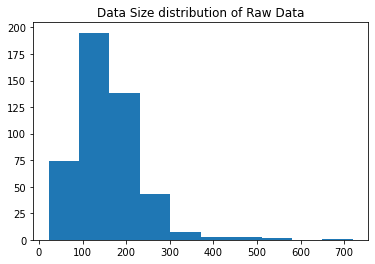

In [5]:
plt.hist(n_data['abstract_list_len'])
plt.title('Data Size distribution of Raw Data')

Text(0.5, 1.0, 'Data Size distribution of Processed Data')

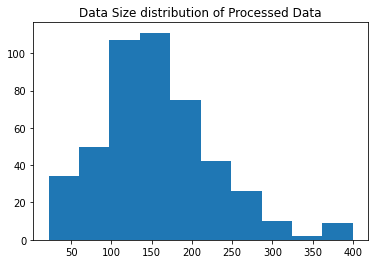

In [6]:
plt.hist(n_data['aabstract_list_trunc_len'])
plt.title('Data Size distribution of Processed Data')

# 5) Cosine SImilarity-

In [7]:
def create_similarity_heatmap(corpus_embeddings):
    similarity_matrix = cosine_similarity(corpus_embeddings)
    sns.set(font_scale=1)
    f, ax = plt.subplots(figsize=(11, 9))
    c = sns.heatmap(similarity_matrix, square=True,  ax=ax)
    c.set(xlabel='Document ID', ylabel='Document ID')
    plt.show()
    fig = c.get_figure()
    fig.suptitle('TF-IDF Document Similarity Matrix', fontsize=25)

# 6) Clustering 

## 6.a) Elbow Plot

In [8]:
def plot_elbow_method(embedding):
  
    Sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(embedding)
        Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

## 6.b) PCA and Kmeans

In [9]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

def get_cluster_kmeans(vectorize, num_clusters, r_state=100):
    km = KMeans(n_clusters = num_clusters, random_state=r_state )
    km.fit(vectorize)
    cluster_list = km.labels_.tolist()
    return cluster_list

def pca_reduction(similarity_matrix, n_components):
    one_min_sim = 1 - similarity_matrix
    pca = PCA(n_components=10)
    pos = pca.fit_transform(one_min_sim)
    x_pos, y_pos = pos[:, 0], pos[:, 1]
    return (x_pos, y_pos)

## 6.c) Plotting Scatter plot -2D

In [10]:
def plot_graph(clusters, umap_data):
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters
    plt.figure(figsize=(10,10))
    sns.scatterplot(
        x="x", y="y",
        hue="labels",
        palette='Spectral',
        data=result,
        legend="full"
    )

# 7) Mean S-BERT Encode 

## 7.a) Initiating the model

In [10]:
from transformers import AutoTokenizer, AutoModel
import torch


#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask



#Sentences we want sentence embeddings for
# sentences = list(n_data['final_text'].values) 

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")
model = AutoModel.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")

#Tokenize sentences
# encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=300, return_tensors='pt')

# #Compute token embeddings
# with torch.no_grad():
#     model_output = model(**encoded_input)

# #Perform pooling. In this case, mean pooling
# sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

In [31]:
not path.exists("data/s_bert.csv")

False

In [32]:
import csv
if not path.exists("data/s_bert.csv"):
    with open('data/s_bert.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        for sentence in n_data['final_text'].values:
            encoded_input = tokenizer(sentence, padding=True, truncation=True, max_length=450, return_tensors='pt')
            with torch.no_grad():
                model_output = model(**encoded_input)
            writer.writerow(mean_pooling(model_output, encoded_input['attention_mask']))

In [33]:
df_sbert = pd.read_csv('data/s_bert.csv',header=None)

In [37]:
s_bert_list =[]
for i in df_sbert[0]:
    s_bert_list.append([float(j) for j in i.replace('\n','').replace('tensor(','').replace(')','').replace('[','').replace(']','').split(',')])

In [38]:
sentence_embeddings_df = pd.DataFrame(s_bert_list)

In [39]:
sentence_embeddings = np.array(sentence_embeddings_df)

## 7.c) Plotting the similarity Matrix

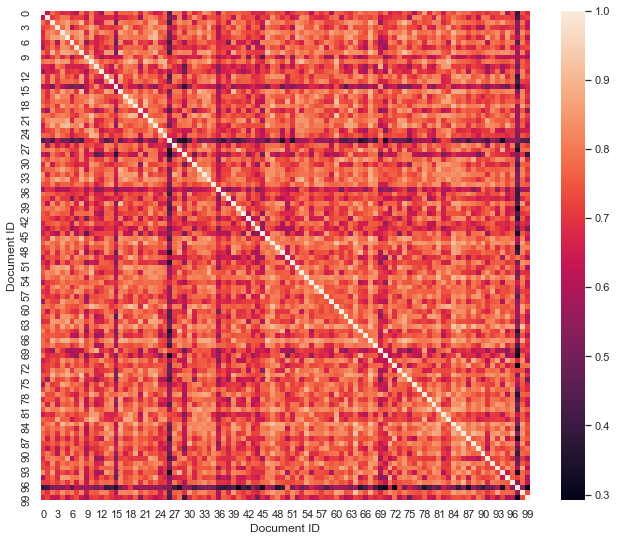

In [42]:
create_similarity_heatmap(sentence_embeddings[100:200,100:200])

### 7.c) KMeans Implementation

### Elbow Method to estimate # of  clusters

C:\Users\rmaka\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  f"KMeans is known to have a memory leak on Windows "


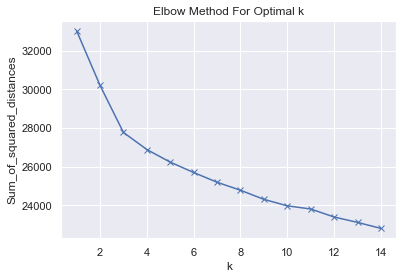

In [43]:
plot_elbow_method(sentence_embeddings)

### PCA plot with KMEANS

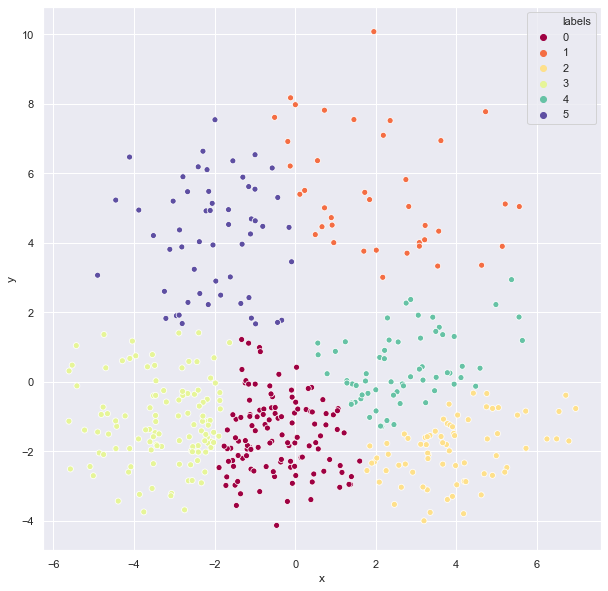

In [22]:
number_of_clusters = 6
x_pos, y_pos = pca_reduction(sentence_embeddings, 2)
df = pd.DataFrame(x_pos,columns = ['x'])
df['y'] = y_pos
df.columns = ['x','y']
km_clusters_s_bert = get_cluster_kmeans(df, number_of_clusters) 
plot_graph(km_clusters_s_bert, df)

# 8) Bert Base Implementation - Last Hidden State


## 8.a) Reading weights for bert Base

In [23]:
try: 
    df_bbw = pd.read_csv('data/Bert_base_weights.csv',header=None)
except Exception as e:
    print(str(e))

for i in range(768):
    df_bbw[i] = df_bbw[i].apply(lambda x : float(str(x).split(',')[0].replace('tensor(','')))

bert_base_embeddings = np.array(df_bbw)

## 8.b) Plotting cosine similarity

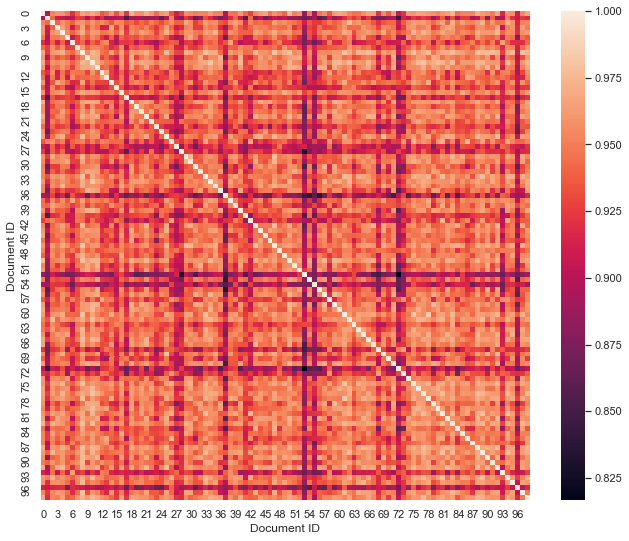

In [24]:
create_similarity_heatmap(bert_base_embeddings[1:100,1:100])

## 8.c) Implementing KMeans and PCA

### Elbow Method to estimate # of  clusters

C:\Users\rmaka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  f"KMeans is known to have a memory leak on Windows "


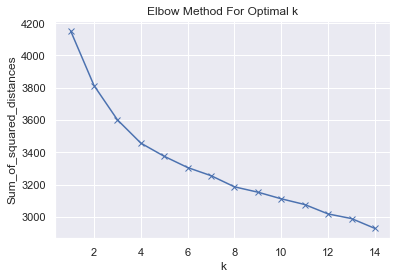

In [25]:
plot_elbow_method(bert_base_embeddings)

### PCA plot with KMEANS

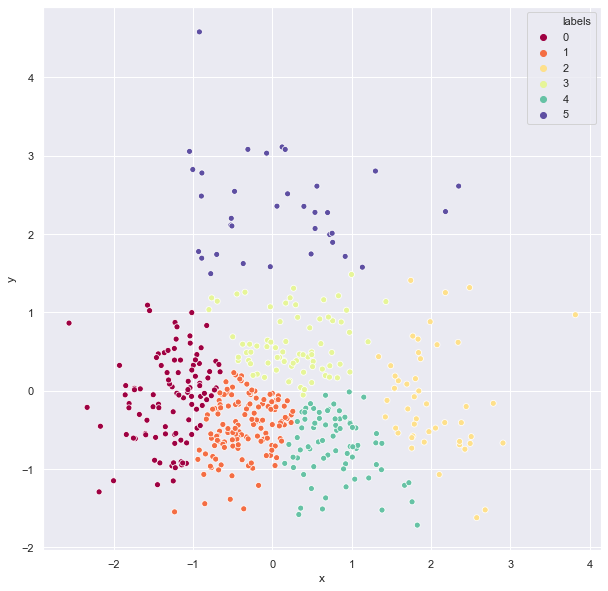

In [26]:
number_of_clusters = 6
x_pos, y_pos = pca_reduction(bert_base_embeddings, 2)
df = pd.DataFrame(x_pos,columns = ['x'])
df['y'] = y_pos
df.columns = ['x','y']
km_clusters_bert_base = get_cluster_kmeans(df, number_of_clusters) 
plot_graph(km_clusters_bert_base, df)

In [29]:
n_data['bert_base_cluster'] = km_clusters_bert_base

# 10) Bert Base Implementation - concat last four Last Hidden State


## 8.a) Reading weights for bert Base

In [30]:
try: 
    df_bbw = pd.read_csv('data/last_four_layer_cat.csv',header=None)
except Exception as e:
    print(str(e))

for i in range(3072):
    df_bbw[i] = df_bbw[i].apply(lambda x : float(str(x).split(',')[0].replace('tensor(','')))

bert_base_fc_embeddings = np.array(df_bbw)

## 8.b) Plotting cosine similarity

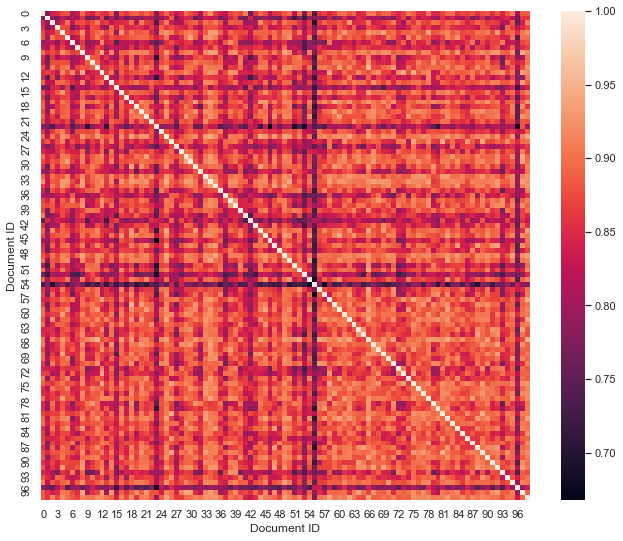

In [32]:
create_similarity_heatmap(bert_base_fc_embeddings[1:100,1:100])

## 8.c) Implementing KMeans and PCA

### Elbow Method to estimate # of  clusters

C:\Users\rmaka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  f"KMeans is known to have a memory leak on Windows "


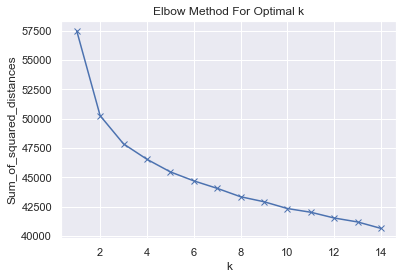

In [33]:
plot_elbow_method(bert_base_fc_embeddings)

### PCA plot with KMEANS

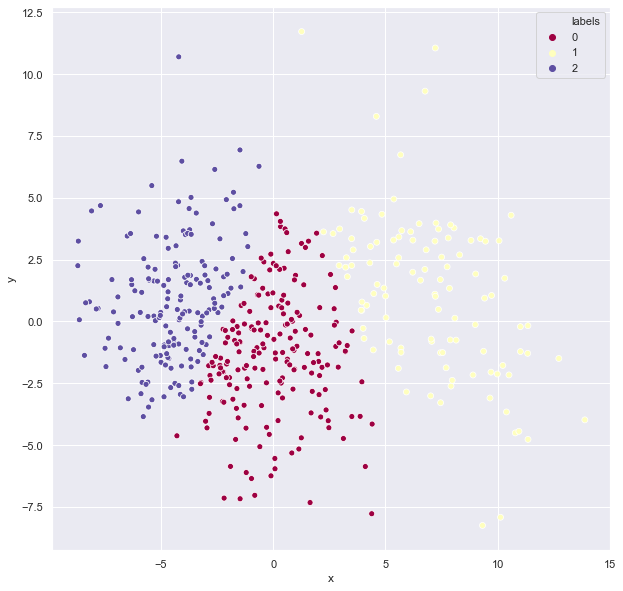

In [34]:

number_of_clusters = 3
x_pos, y_pos = pca_reduction(bert_base_fc_embeddings, 2)
df = pd.DataFrame(x_pos,columns = ['x'])
df['y'] = y_pos
df.columns = ['x','y']
km_clusters_bert_fc_base = get_cluster_kmeans(df, number_of_clusters) 
plot_graph(km_clusters_bert_fc_base, df)

In [35]:
n_data['km_clusters_bert_fc_base'] = km_clusters_bert_fc_base

# 11) Mean Bert Base Implementation


## 8.a) Reading weights for bert Base

In [36]:
try: 
    df_bbw = pd.read_csv('data/mean_bert_base.csv',header=None)
except Exception as e:
    print(str(e))

for i in range(768):
    df_bbw[i] = df_bbw[i].apply(lambda x : float(str(x).split(',')[0].replace('tensor(','')))

bert_base_mean_embeddings = np.array(df_bbw)

## 8.b) Plotting cosine similarity

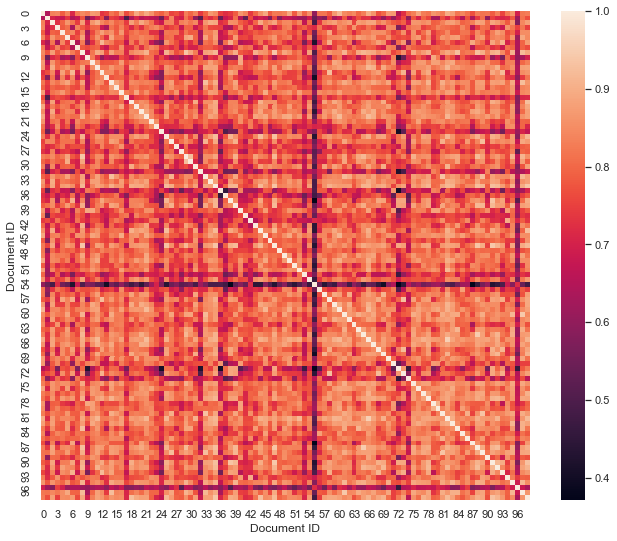

In [38]:
create_similarity_heatmap(bert_base_mean_embeddings[1:100,1:100])

## 8.c) Implementing KMeans and PCA

### Elbow Method to estimate # of  clusters

C:\Users\rmaka\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  f"KMeans is known to have a memory leak on Windows "


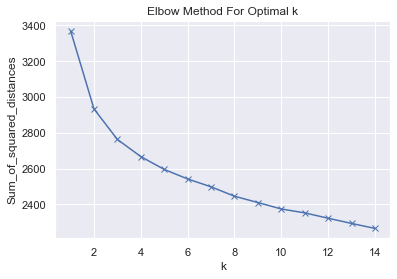

In [39]:
plot_elbow_method(bert_base_mean_embeddings)

### PCA plot with KMEANS

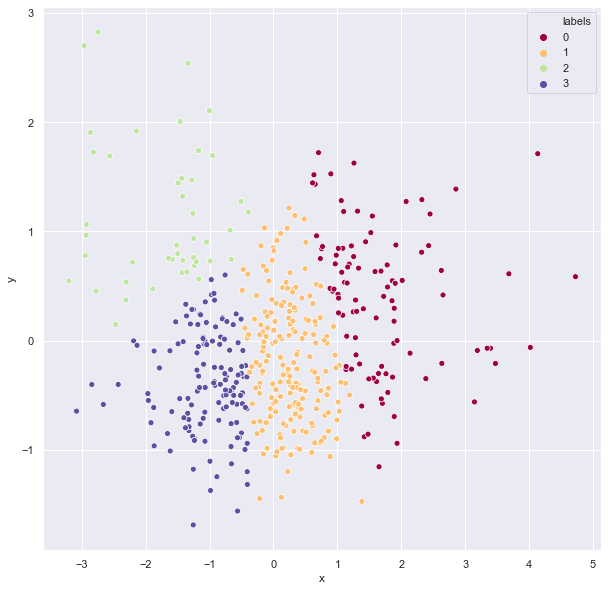

In [40]:
# number_of_clusters = 8
# km_clusters_bert_base = get_cluster_kmeans(bert_base_embeddings, number_of_clusters) # 466 X 768 
# x_pos, y_pos = pca_reduction(bert_base_embeddings, 2)
# scatter_clusters(x_pos, y_pos, km_clusters_bert_base)

number_of_clusters = 4 
x_pos, y_pos = pca_reduction(bert_base_mean_embeddings, 2)
df = pd.DataFrame(x_pos,columns = ['x'])
df['y'] = y_pos
df.columns = ['x','y']
km_clusters_bert_mean_base = get_cluster_kmeans(df, number_of_clusters) 
plot_graph(km_clusters_bert_mean_base, df)

In [41]:
n_data['km_clusters_bert_mean_base'] = km_clusters_bert_mean_base

In [43]:
n_data.to_csv('data/output_file.csv')